<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Redes Convolucionales y sus aplicaciones </H3>
<H3 align='center'>  Jorge Portilla - John Rodriguez </H3>

<hr style="height:2px;border:none"/>

# Convolutional Neural Networks (CNN) en CIFAR

Se trabajará con el dataset CIFAR10, que esta compuesto por un conjunto de 60.000 imágenes RGB de 32 × 32 pixeles que contiene 10 clases de objetos y **6000 ejemplos por clase**. La versión utilizada se le atribuye a *A. Krizhevsky, V. Nair* y *G. Hinton* y viene separada en **50000 ejemplos de entrenamiento** y **10000 casos de prueba** que fueron obtenidos seleccionando 1000 imágenes aleatorias de cada clase.

Los datos restantes han sido ordenados aleatoriamente y están organizados en **5 bloques de entrenamiento o batches**. Cabe destacar que las clases son mutuamente excluyentes y corresponden a las siguientes categorı́as: 

* Gato
* Perro
* Rana
* Caballo
* Pájaro
* Ciervo
* Avión
* Automóvil
* Camión 
* Barco

Para esta tarea se experimentará con redes convolucionales, conocidas como CNNs.

In [1]:
#Librerías y modulos a usar
import numpy as np   
import os   
from keras.datasets import cifar10
import keras
import pandas as pd
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.


## Pregunta A

> Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema CIFAR generando como salida:
+ dos matrices  Xtr, Ytr; correspondientes a las imágenes y etiquetas de entrenamiento,
+ dos matrices Xt, Yt; correspondientes a las imágenes y etiquetas de pruebas,
+ dos matrices Xv, Yv; correspondientes a las imágenes y etiquetas que se usarán como conjunto de validación (para tomar decisiones de diseño acerca del modelo).
**Este último conjunto debe ser extraı́do desde el conjunto de entrenamiento original y no debe superar las 5000 imágenes.**

La función loadCifar10 crea los conjuntos de training, validación y testing, donde se tiene 90% de training y 10% de validación, para no superar las 5000 imágenes de validación.

In [2]:
def loadCifar10():
    label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    #60% of the data for training, 40% for validation
    x_train, x_val = np.vsplit(x_train, [int(0.9*x_train.shape[0])])
    y_train, y_val = np.vsplit(y_train, [int(0.9*y_train.shape[0])])
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

Usando la función anterior cargamos los conjuntos.

In [3]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = loadCifar10()

## Pregunta B

> Prepare subconjuntos de entrenamiento, validación y pruebas normalizando las imágenes de entrenamiento y pruebas, dividiendo las intensidades originales de pixel en cada canal por 255.  Es importante notar que si desea trabajar con el orden de las dimensiones denominado ’tf’ (por defecto para TensorFlow) deberá realizar la transposición correspondiente para dejar el canal en donde corresponda. Finalmente, genere una representación adecuada de las salidas deseadas de la red.

Se normaliza cada uno de los conjuntos de características, dividiendolos por 255, y categorizamos los conjuntos target.

In [4]:
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
y_val = keras.utils.to_categorical(y_val, 10)

## Pregunta C

> Defina una CNN con arquitectura $C \times P \times C \times P \times F \times F$. Para ambas capas convolucionales utilice 64 filtros de $3 \times 3$ y funciones de activación ReLU. Para las capas de pooling utilice filtros de $2 \times 2$ con stride 2. Para la capa MLP escondida use 512 neuronas. Genere un esquema lo más compacto posible que muestre los cambios de forma (dimensionalidad) que experimenta un patrón de entrada a medida que se ejecuta un forward-pass y el número de parámetros de cada capa.

Se crea un modelo *Sequential* usando keras, añadiendole las diferentes capas que se mencionan. Luego, se muestra una tabla la cual mustra las características de las capas, su dimensiones y sus parámetros.

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', input_shape = x_train.shape[1:]))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

## Pregunta D

>  Entrene la CNN definida en **c)** utilizando SGD. En este dataset, una tasa de aprendizaje “segura” es $\eta = 10^{-4}$ o inferior, pero durante las primeras *epochs* el entrenamiento resulta demasiado lento. Para resolver el problema aprenderemos a controlar la tasa de aprendizaje utilizada en el entrenamiento. Implemente la siguiente idea: deseamos partir con una tasa de aprendizaje $\eta = 10^{-3}$ y dividir por 2 ese valor cada 10 epochs. Suponga además que no queremos usar una tasa de aprendizaje menor a $\eta = 10^{-5}$.  Construya un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de “epochs”, entrene con 25 *epochs*.

Primero, se crea la clase **TestCallback** para poder guardar el error y la precisión al evaluar el modelo en el conjunto de testing en cada una de las epochs, no solo al final.

In [5]:
class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        test_loss.append(loss)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

Se crea la función **step_decay**, la cual determinará el learning rate en cada una de las epochs siguiendo la idea de comenzar con un learning rate más pequeño y luego ir aumentandolo.

In [6]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((1+epoch)/5))
    lrate = max(lrate,0.00001)
    return lrate

Se procede a realizar el experimento usando el modelo creado en **c)**. Se compila el modelo usando como optimizador un SGD, se usa categorical crossentropy para el error y además medimos la precisión del modelo.

In [12]:
test_loss = []
opt = keras.optimizers.SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = keras.callbacks.LearningRateScheduler(step_decay)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
history_1d = model.fit(x_train, y_train,batch_size = 32, epochs = 25, validation_data=(x_val,y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)),lrate])
history_1d.history["test_loss"] = test_loss
result = pd.DataFrame(hystory_1d.history)
result.to_csv("history_1d.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
44960/45000 [============================>.] - ETA: 0s - loss: 1.9503 - acc: 0.2990
Testing loss: 1.6866544523239135, acc: 0.4118

45000/45000 [==============================] - 26s - loss: 1.9500 - acc: 0.2991 - val_loss: 1.7048 - val_acc: 0.3938
Epoch 2/25
44896/45000 [============================>.] - ETA: 0s - loss: 1.5600 - acc: 0.4453
Testing loss: 1.4402217903137207, acc: 0.487

45000/45000 [==============================] - 20s - loss: 1.5601 - acc: 0.4452 - val_loss: 1.4563 - val_acc: 0.4756
Epoch 3/25
44992/45000 [============================>.] - ETA: 0s - loss: 1.3778 - acc: 0.5120
Testing loss: 1.3094421035766601, acc: 0.54

45000/45000 [==============================] - 20s - loss: 1.3777 - acc: 0.5120 - val_loss: 1.3114 - val_acc: 0.5392
Epoch 4/25
44960/45000 [============================>.] - ETA: 0s - loss: 1.2604 - acc: 0.5550
Testing loss: 1.2406502838134765, acc: 0.5606

45000/45000 [======================

Una vez realizado el entrenamiento, se gráfican las curvas de error del entrenamiento, validación y testing en función del número de epochs. Con este fin se crea la función **plotCurves**, que gráfica el conjunto de curvas que se le dan como parametro.

In [31]:
def plotCurves(curves, labels, title, legends):
    plt.figure(1, figsize=(14, 10))
    for C in curves:
        plt.plot(range(1, len(C)+1), C)
    plt.ylabel(labels[1])
    plt.xlabel(labels[0])
    plt.title(title)
    plt.grid(True)
    plt.legend(legends)
    plt.show()

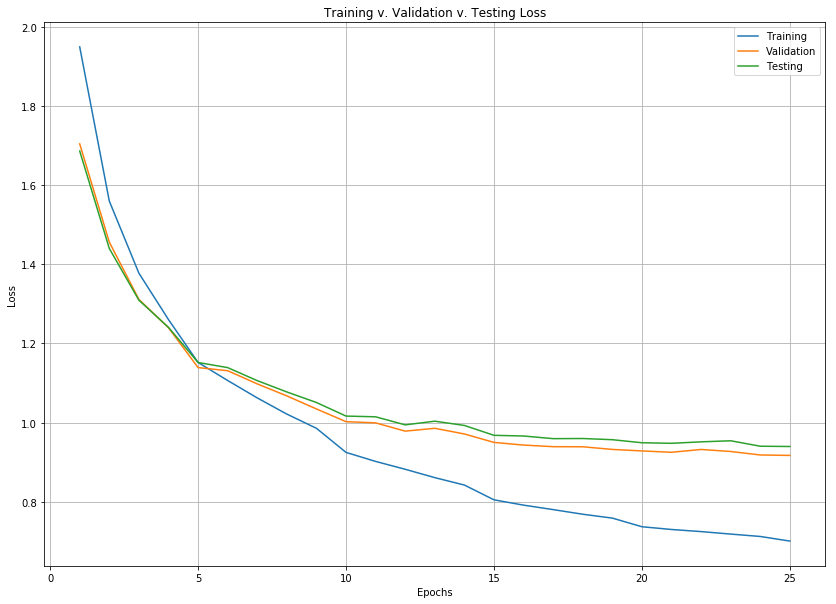

In [32]:
history_1d = pd.read_csv("history_1d.csv")
plotCurves([history_1d['loss'], history_1d['val_loss'], history_1d['test_loss']], ['Epochs', 'Loss'], 'Training v. Validation v. Testing Loss', ['Training', 'Validation','Testing'])

Se puede notar que gracias a la modificación del learning rate los tiempos de espera en un inicio son menores comparados con otros entrenamientos. El error en el conjunto de entrenamiento es menor que el error en el conjunto de validación y testing, siendo estos últimos muy parecidos.

## Pregunta E

> Entrene la CNN definida en c) utilizando **RMSProp** durante 25 *epochs*. Elija la función de pérdida más apropiada para este problema. Construya finalmente un gráfico que muestre los errores de entrenamiento, validación y pruebas como función del número de *epochs*.
*Hint: La curva sugiere algún cambio en el modelo definido, considere ésto en cuenta para las experimentaciones futuras.*

Primero, se cream el modelo de la misma manera que en **c)**.

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', input_shape = x_train.shape[1:]))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation('softmax'))

Se compila usando el optimizador RMSProp y se entrena el modelo.

In [33]:
test_loss = []
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
history_1e = model.fit(x_train, y_train, batch_size= 32, epochs = 25, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test))])
history_1e.history["test_loss"] = test_loss
result_1e = pd.DataFrame(history_1e.history)
result_1e.to_csv("history_1e.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
44992/45000 [============================>.] - ETA: 0s - loss: 1.3474 - acc: 0.5229
Testing loss: 1.131482534790039, acc: 0.6052

45000/45000 [==============================] - 23s - loss: 1.3473 - acc: 0.5229 - val_loss: 1.1133 - val_acc: 0.6216
Epoch 2/25
44992/45000 [============================>.] - ETA: 0s - loss: 0.9598 - acc: 0.6656
Testing loss: 1.3272545824050903, acc: 0.5809

45000/45000 [==============================] - 22s - loss: 0.9597 - acc: 0.6657 - val_loss: 1.2874 - val_acc: 0.5956
Epoch 3/25
44896/45000 [============================>.] - ETA: 0s - loss: 0.7873 - acc: 0.7288
Testing loss: 1.0413120856285096, acc: 0.6709

45000/45000 [==============================] - 21s - loss: 0.7867 - acc: 0.7291 - val_loss: 1.0047 - val_acc: 0.6854
Epoch 4/25
44960/45000 [============================>.] - ETA: 0s - loss: 0.6623 - acc: 0.7754
Testing loss: 1.1080458763122558, acc: 0.6697

45000/45000 [====================

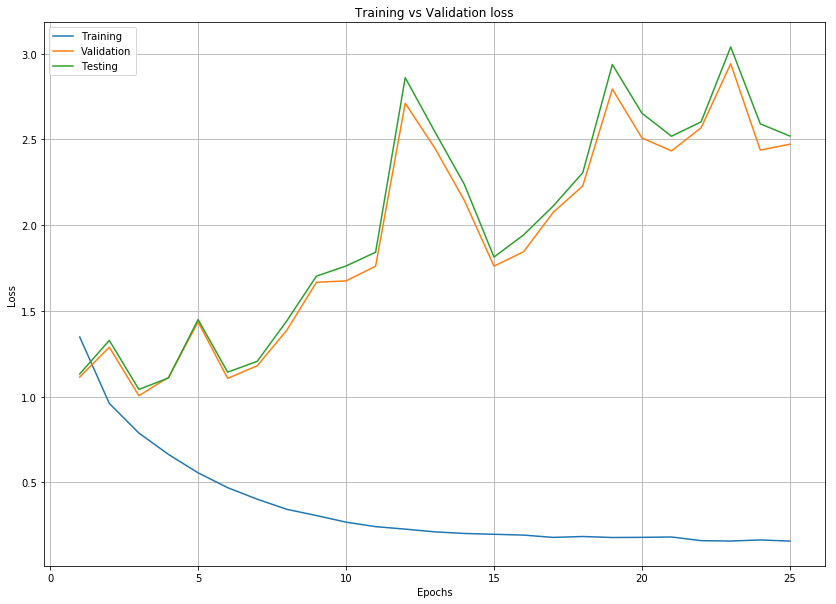

In [33]:
history_1e = pd.read_csv("history_1e.csv")
plotCurves([history_1e['loss'], history_1e['val_loss'], history_1e['test_loss']], ['Epochs', 'Loss'], 'Training vs Validation loss', ['Training', 'Validation','Testing'])

Analizando el gráfico, se puede indicar que se produce **overfitting**, es decir, el modelo aprende muy bien el conjunto de entrenamiento, pero le cuesta predecir generalizaciones, como se puede apreciar al ver como el error converge en la validación y el testing.

Para disminuir el overfitting se utilizaran regularizadores l2 en cada una de las capas de convolución y una capa de Drouput luego de cada capa de Pooling.

In [66]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', input_shape = x_train.shape[1:], kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Activation('softmax'))

In [70]:
test_loss = []
opt = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
history_1e_alt = model.fit(x_train, y_train, batch_size= 32, epochs = 25, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test))])
history_1e_alt.history["test_loss"] = test_loss
result_1e_alt = pd.DataFrame(history_1e_alt.history)
result_1e_alt.to_csv("history_1e_alt3.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
44928/45000 [============================>.] - ETA: 0s - loss: 1.2116 - acc: 0.6424
Testing loss: 1.1245279762268066, acc: 0.672

45000/45000 [==============================] - 18s - loss: 1.2117 - acc: 0.6424 - val_loss: 1.1126 - val_acc: 0.6782
Epoch 2/25
44800/45000 [============================>.] - ETA: 0s - loss: 1.1807 - acc: 0.6450
Testing loss: 1.1282552764892577, acc: 0.6678

45000/45000 [==============================] - 18s - loss: 1.1808 - acc: 0.6451 - val_loss: 1.1065 - val_acc: 0.6796
Epoch 3/25
44800/45000 [============================>.] - ETA: 0s - loss: 1.1660 - acc: 0.6524
Testing loss: 1.1686703607559203, acc: 0.6447

45000/45000 [==============================] - 18s - loss: 1.1652 - acc: 0.6526 - val_loss: 1.1420 - val_acc: 0.6614
Epoch 4/25
44800/45000 [============================>.] - ETA: 0s - loss: 1.1610 - acc: 0.6509
Testing loss: 1.1604280046463014, acc: 0.6528

45000/45000 [====================

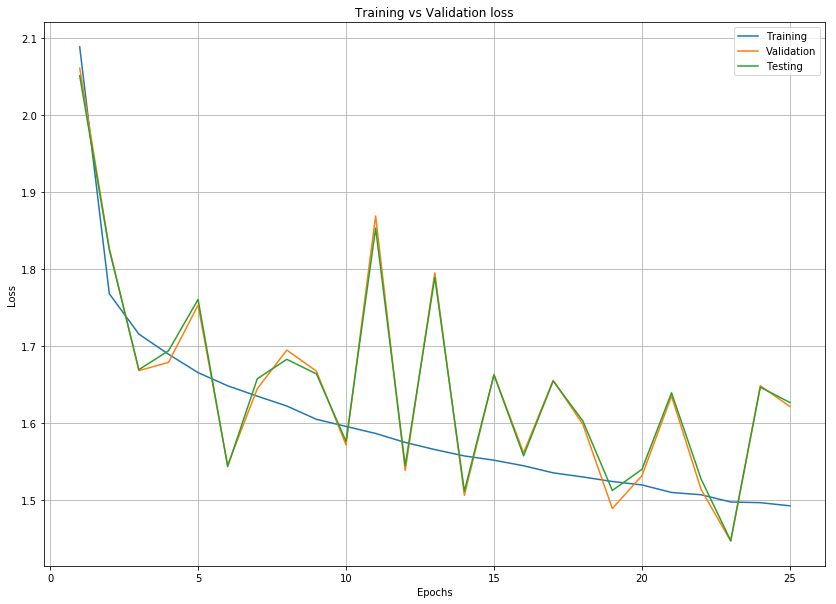

In [34]:
history_1e_alt = pd.read_csv("history_1e_alt3.csv")
plotCurves([history_1e_alt['loss'], history_1e_alt['val_loss'], history_1e_alt['test_loss']], ['Epochs', 'Loss'], 'Training vs Validation loss', ['Training', 'Validation','Testing'])

De esta manera podemos obtener un resultado con menos overfitting en el entranamiento y un mejor comportamiento en los conjuntos de validación y testing.

## Pregunta F

> Evalúe el efecto de modificar el tamaño de los filtros (de convolución) reportando la sensibilidad del error de pruebas a estos cambios en dos tipos de arquitecturas, una profunda y otra no. Presente un gráfico o tabla resumen. Por simplicidad entre durante sólo 15-20 *epochs*.

Primero veremos el efecto de modificar el tamaño de los filtros en una red **shallow**. Esta contará con una capa **convolucional** con 64 feature maps, donde los filtros tendrán tamaño 2, 3, 6 y 9. Luego se usa una capa **pooling** con filtro de tamaño 2, seguida de una capa de 512 neuronas con función de activación **relu**, para finalmente terminar con la capa final con 10 neuronas con función de activación **softmax**.

In [9]:
histories = dict()
for nc in [9, 6, 3, 2]:
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, (nc, nc), padding='same', input_shape=x_train.shape[1:]))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.Activation('softmax'))
    test_loss = []
    opt = keras.optimizers.SGD(lr=0.0, momentum=0.9, decay=0.0)
    lrate = keras.callbacks.LearningRateScheduler(step_decay)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size= 32, epochs = 15, validation_data=(x_val, y_val), shuffle=True, callbacks=[TestCallback((x_test, y_test)), lrate])
    history.history["test_loss"] = test_loss
    histories[nc] = pd.DataFrame(history.history)

result = pd.concat(histories)
result.to_csv("history_1f_alt2.csv")

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
44960/45000 [============================>.] - ETA: 0s - loss: 1.7568 - acc: 0.3694
Testing loss: 1.5230673030853272, acc: 0.455

45000/45000 [==============================] - 34s - loss: 1.7568 - acc: 0.3693 - val_loss: 1.5356 - val_acc: 0.4484
Epoch 2/15
44960/45000 [============================>.] - ETA: 0s - loss: 1.4292 - acc: 0.4884
Testing loss: 1.3902726831436156, acc: 0.5145

45000/45000 [==============================] - 28s - loss: 1.4292 - acc: 0.4884 - val_loss: 1.3887 - val_acc: 0.5118
Epoch 3/15
44992/45000 [============================>.] - ETA: 0s - loss: 1.3086 - acc: 0.5371
Testing loss: 1.2996790021896363, acc: 0.541

45000/45000 [==============================] - 27s - loss: 1.3086 - acc: 0.5371 - val_loss: 1.2978 - val_acc: 0.5456
Epoch 4/15
44928/45000 [============================>.] - ETA: 0s - loss: 1.2189 - acc: 0.5740
Testing loss: 1.1996516265869142, acc: 0.5775

45000/45000 [=====================

Graficamos los 4 casos modelados para los errores de entrenamiento, validación y testing.

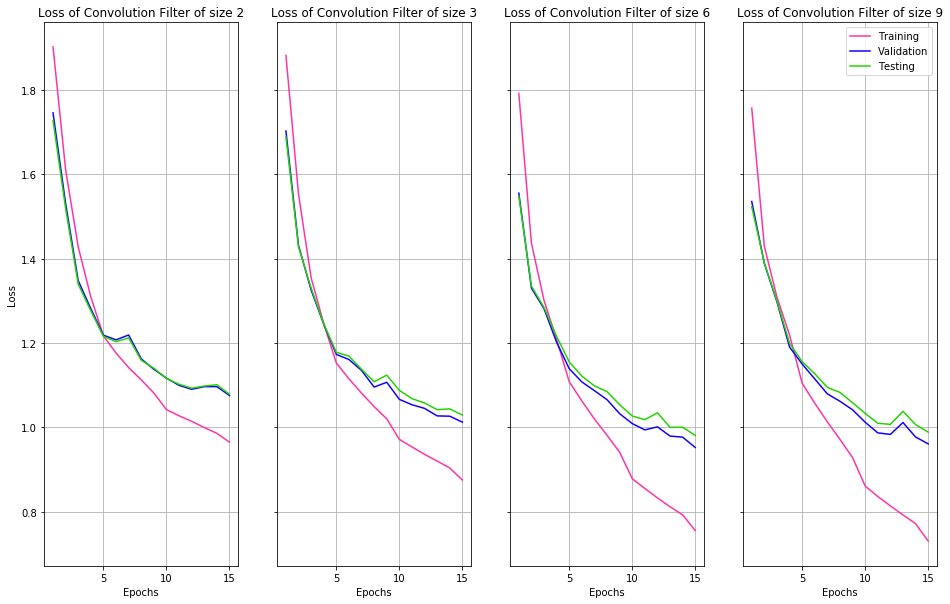

In [45]:
histories_1f = pd.read_csv("history_1f_alt2.csv", dtype={'Unnamed: 0':int,'Unnamed: 1':int,'val_loss':float,
                                                    'loss': float}, index_col=[0,1], skipinitialspace=True)

nc = [2, 3, 6, 9]
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
for i in range(len(nc)):
    axes[i].plot(range(1, 16), histories_1f['loss'][nc[i]], '#ff33a3', label = "Training")
    axes[i].plot(range(1, 16), histories_1f['val_loss'][nc[i]], '#1300FF', label = "Validation")
    axes[i].plot(range(1, 16), histories_1f['test_loss'][nc[i]], '#23D300', label = "Testing")
    axes[i].grid(True)
    axes[i].set_title("Loss of Convolution Filter of size "+str(nc[i]))
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

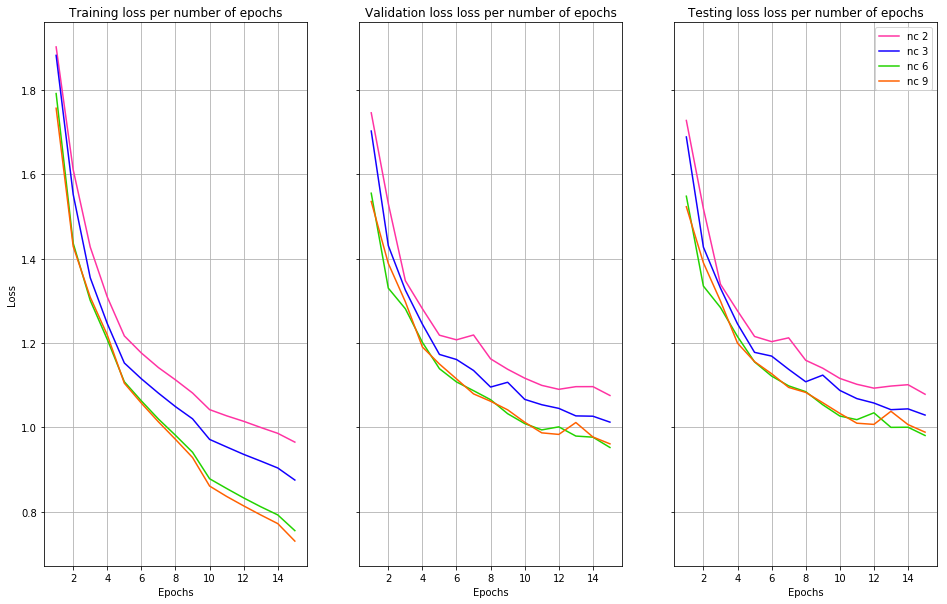

In [44]:
f, axes = plt.subplots(1, 3, sharey=True, figsize=(16, 10))
axes[0].set_ylabel("Loss")
losses = ["loss", "val_loss", "test_loss"]
titles = ["Training", "Validation loss", "Testing loss"]
for i in range(3):
    axes[i].plot(range(1, 16), histories_1f[losses[i]][2], '#ff33a3', label = "nc 2")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][3], '#1300FF', label = "nc 3")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][6], '#23D300', label = "nc 6")
    axes[i].plot(range(1, 16), histories_1f[losses[i]][9], '#FF6100', label = "nc 9")
    axes[i].grid(True)
    axes[i].set_title(titles[i]+" loss per number of epochs")
    axes[i].set_xlabel("Epochs")
axes[-1].legend()
plt.show()

Podemos notar que ha medida que aumentamos el tamaño del filtro de convolución los errores en todos los conjuntos disminuyen. **Continuar análisis**

## Pregunta G

> Se ha sugerido que la práctica bastante habitual de continuar una capa convolucional con una capa de *pooling* puede generar una reducción prematura de las dimensiones del patrón de entrada. Experimente con una arquitectura del tipo $C \times P \times C \times P \times F \times F$ versus  $C \times C \times P \times C \times C \times P \times F \times F$. Use 64 filtros para la primera capa convolucional y 128 para la segunda (o 64 filtros para las primeras 2 capas convolucionales y 128 para las dos últimas).

> Reflexione sobre qué le parece más sensato: ¿qué estructura permite un mejor desempeño y/o extracción de atributos de interés?¿es aconsejable mantener el tamaño de los filtros usados anteriormente (pregunta anterior)? o ¿usar filtros más grandes en la segunda capa convolucional y más pequeños en la primera? o ¿usar filtros más pequeños en la segunda capa convolucional y más grandes en la primera?  
> **Hint:** con esta nueva arquitectura debiese superar el 70% de accuracy (de validación/test) antes de 5 epochs, pero la arquitectura es más sensible a overfitting por lo que podrı́a ser conveniente agregar un regularizador. Como resultado final de esta actividad gráfique los errores de entrenamiento, validación y pruebas como función del número de “epochs” (fijando el máximo en un número razonable como T = 25).